#  Spatio-Temporal Prediction and Coordination of EV Charging Demand for Power System Resilience

## Research Objectives

Recent studies have explored electric vehicles (EVs) from different perspectives, ranging from estimating vehicle range based on battery capacity, model specifications, and internal components (Ahmed et al., 2022) to forecasting charging behavior using machine learning methods such as Random Forest and SVM with factors like previous payment data, weather, and traffic (Shahriar et al., 2020). In parallel, research on smart cities has focused on managing traffic flow efficiently to reduce congestion and energy consumption (Dymora, Mazurek, & Jucha, 2024).

Building on these insights, this study links traffic dynamics with EV energy consumption to better predict when and where charging demand will arise. By integrating spatio-temporal traffic features with deep learning models, the goal is to anticipate EV charging needs in real time and enable coordinated charging strategies that support overall power system resilience.


## Load Required Libraries 

In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Load and Clean the Data 

In [81]:
df = pd.read_csv("cleaned_traffic_data.csv")

## How the data looks directly from PEMS

In [82]:
df.head()

,Timestamp,Station,District,Route,Direction of Travel,Lane Type,Station Length,Samples,% Observed,Total Flow,...,Lane 5 Avg Speed,Lane 6 Flow,Lane 6 Avg Occ,Lane 6 Avg Speed,Lane 7 Flow,Lane 7 Avg Occ,Lane 7 Avg Speed,Lane 8 Flow,Lane 8 Avg Occ,Lane 8 Avg Speed
0,10/01/2024 00:00:00,308512,3,50,W,ML,3.9950,197,0,497.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/01/2024 00:00:00,311831,3,5,S,OR,NaN,101,92,27.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10/01/2024 00:00:00,311832,3,5,S,FR,NaN,101,92,78.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10/01/2024 00:00:00,311844,3,5,N,OR,NaN,202,92,43.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10/01/2024 00:00:00,311847,3,5,N,OR,NaN,303,92,73.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We ignore and remove features that contain only NAN values, and maintain the other features.

In [83]:
# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [84]:
df

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0000,64.1000,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0000,NaN,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0000,NaN,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0000,NaN,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0000,NaN,92,303,OR
...,...,...,...,...,...,...,...,...,...
4114675,12/31/2024 23:00:00,3423094,99,S,68.0000,64.8000,96,118,ML
4114676,12/31/2024 23:00:00,3900021,50,E,803.0000,66.5000,67,292,ML
4114677,12/31/2024 23:00:00,3900022,50,E,509.0000,68.0000,0,0,HV
4114678,12/31/2024 23:00:00,3900023,50,W,881.0000,67.4000,67,289,ML


## Check the data types 

In [85]:
df.dtypes

Timestamp               object
Station                  int64
Route                    int64
Direction of Travel     object
Total Flow             float64
Avg Speed              float64
% Observed               int64
Samples                  int64
Lane Type               object
dtype: object

## Check the Percent of Missing Data in every feature 

In [86]:
pd.set_option('display.float_format', '{:.4f}'.format)

missing_percent = (df.isna().sum() / len(df)) * 100
print(missing_percent)


Timestamp              0.0000
Station                0.0000
Route                  0.0000
Direction of Travel    0.0000
Total Flow             7.3827
Avg Speed             38.4621
% Observed             0.0000
Samples                0.0000
Lane Type              0.0000
dtype: float64


## Imputation Strategy for Key Traffic Variables

We decided to retain both the Average Speed and Total Flow features instead of dropping them because they are core variables that capture the essence of traffic dynamics. Average Speed reflects congestion levels and driving conditions, while Total Flow represents the number of vehicles passing a station—both directly influencing how traffic impacts EV range and, ultimately, charging demand. Dropping them would mean ignoring the very behaviors that determine how energy is consumed on the road. Even though these features had missing values, the patterns in traffic data are strongly structured in time and space, making them ideal candidates for informed imputation rather than removal.

For Average Speed, we applied a two-step temporal–spatial imputation strategy. First, we used forward and backward filling within each station to maintain continuity and preserve the natural hourly flow of traffic data. This approach works well because traffic speed rarely changes abruptly from one hour to the next unless influenced by an external event.

For Total Flow, the missingness was much lower, so a simpler approach was sufficient. We performed linear interpolation within each station to fill in small hourly gaps, ensuring that flow values remained smooth and representative of actual traffic movement. These imputation steps allowed us to preserve critical information about how vehicles move through the network without introducing artificial noise or bias. By reconstructing rather than discarding incomplete data, we maintained the integrity of the dataset and strengthened the foundation for accurate spatio-temporal modeling of EV charging demand and range prediction.

In [87]:
df.sort_values(['Station', 'Timestamp'], inplace=True)
df['Avg Speed'] = df.groupby('Station')['Avg Speed'].ffill().bfill()

In [88]:
df['Total Flow'] = df.groupby('Station')['Total Flow'].transform(
    lambda x: x.interpolate(method='linear')
)

## How the data Looks Like Now 

In [89]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type
1827,10/01/2024 01:00:00,308511,50,E,12.0000,67.5000,100,202,ML
3688,10/01/2024 02:00:00,308511,50,E,12.0000,67.0000,100,197,ML
5549,10/01/2024 03:00:00,308511,50,E,20.0000,66.3000,92,197,ML
7410,10/01/2024 04:00:00,308511,50,E,55.0000,67.4000,100,197,ML
9271,10/01/2024 05:00:00,308511,50,E,228.0000,66.1000,83,168,ML


# Feature Engineering 

## How do we incoporate and account for the spatial relationship in our data ?

### Incorporating Spatial Features into Linear Regression Models

To rigorously incorporate spatial features into linear regression models for the  PEMS-based traffic data, a systematic statistical approach is essential. Each record contains Station, Route, and Direction of Travel, which are sufficient for defining physical proximity. For each station, we partition the dataset by Route and Direction of Travel, then sort by Station ID. This ordering leverages the typical installation sequence of PEMS sensors and is supported in transportation literature when actual milepost data are unavailable.

For any station $s$ at time $t$, let the set of spatial neighbors (commonly the immediate upstream and downstream stations) be denoted as $\mathcal{N}(s)$. The flow at station $s$, $y_{s,t}$, is modeled as a function of its own temporal history and the flows of neighboring stations:

$$
y_{s,t} = \beta_0 + \sum_{k=1}^{p} \beta_k x_{s,t-k} + \sum_{j \in \mathcal{N}(s)} \gamma_j y_{j,t-l_j} + \epsilon_{s,t}
$$

Here:
- $x_{s,t-k}$ represents temporal features (including lagged flows at station $s$)  
- $y_{j,t-l_j}$ are flows at adjacent stations $j$, possibly with their own lags $l_j$   NB: for the neighboring stations we consider t, t-1 and t-2 
- $\beta_k$ and $\gamma_j$ are regression coefficients  
- $\epsilon_{s,t}$ is the error term  

This formulation captures spatial correlation as conditional dependence between adjacent sites, following spatial autoregressive principles within a linear regression framework.

In practice, using Python (pandas), after grouping by Route and Direction of Travel and sorting by Station, we generate for each observation the "upstream flow" and "downstream flow" variables, optionally at various lags (e.g., current or one-hour prior). These neighbor-based features are then included alongside traditional temporal predictors during model training. This ensures that spatial propagation and congestion effects, which are core to traffic dynamics, are represented in the model.

This approach ensures that even without explicit geo-coordinates, the regression model effectively captures spatial dependencies, leading to more accurate and interpretable traffic flow predictions across the studied transportation corridor.


In [90]:
import pandas as pd

grp_keys = ["Route", "Direction of Travel"]

#  Get unique stations per corridor with their spatial rank
corridor_stations = (
    df.groupby(grp_keys)["Station"]
    .unique()
    .apply(sorted)
    .reset_index()
    .rename(columns={"Station": "stations_list"})
)

# Explode to create a lookup table
neighbor_map = corridor_stations.explode("stations_list").reset_index(drop=True)
neighbor_map["station_rank"] = neighbor_map.groupby(grp_keys).cumcount()

# Create upstream/downstream mappings
neighbor_map["upstream_station"] = neighbor_map.groupby(grp_keys)["stations_list"].shift(1)
neighbor_map["downstream_station"] = neighbor_map.groupby(grp_keys)["stations_list"].shift(-1)

#  Merge back to original data
df = df.merge(
    neighbor_map.rename(columns={"stations_list": "Station"}),
    on=grp_keys + ["Station"],
    how="left"
)


In [91]:
# See all unique combinations
df[['Route', 'Direction of Travel', 'Station', 'upstream_station', 'downstream_station']]\
  .drop_duplicates()\
  .sort_values(['Route', 'Direction of Travel', 'Station'])


,Route,Direction of Travel,Station,upstream_station,downstream_station
8829,5,N,311844,NaN,311847
11037,5,N,311847,311844,311864
13245,5,N,311864,311847,312133
48573,5,N,312133,311864,312134
50781,5,N,312134,312133,314780
...,...,...,...,...,...
2184496,267,W,320332,319284,NaN
620215,275,W,314530,NaN,316106
1075063,275,W,316106,314530,NaN
3404652,505,N,3085051,NaN,NaN


In [92]:
# Look at Station 311903 instead
df[df['Station'] == 311903].head()


,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type,station_rank,upstream_station,downstream_station
15453,10/01/2024 00:00:00,311903,50,E,1198.0000,66.6000,0,300,ML,1,308511,311930
15454,10/01/2024 01:00:00,311903,50,E,1085.0000,66.3000,0,303,ML,1,308511,311930
15455,10/01/2024 02:00:00,311903,50,E,960.0000,66.1000,0,297,ML,1,308511,311930
15456,10/01/2024 03:00:00,311903,50,E,988.0000,66.4000,0,297,ML,1,308511,311930
15457,10/01/2024 04:00:00,311903,50,E,1325.0000,66.8000,0,297,ML,1,308511,311930


In [93]:
def merge_neighbor_flows(df, neighbor_col, new_col_prefix):
    '''
    Merge neighbor flows with t, t-1, t-2 lags
    
    Parameters:
    -----------
    df : DataFrame with upstream_station/downstream_station columns
    neighbor_col : str, name of the neighbor column ('upstream_station' or 'downstream_station')
    new_col_prefix : str, prefix for new columns ('upstream' or 'downstream')
    '''
    
    # Create lookup table
    neighbor_flow = df[['Station', 'Timestamp', 'Total Flow']].copy()
    neighbor_flow.rename(columns={'Station': neighbor_col}, inplace=True)
    
    # Merge current hour (t)
    df = df.merge(
        neighbor_flow.rename(columns={'Total Flow': f'{new_col_prefix}_flow'}),
        on=[neighbor_col, 'Timestamp'],
        how='left'
    )
    
    # Create lag 1 (t-1)
    df[f'{new_col_prefix}_flow_lag1'] = df.groupby(neighbor_col)[
        f'{new_col_prefix}_flow'
    ].shift(1)
    
    # Create lag 2 (t-2)
    df[f'{new_col_prefix}_flow_lag2'] = df.groupby(neighbor_col)[
        f'{new_col_prefix}_flow'
    ].shift(2)
    
    return df


# Now apply the function

# Apply to upstream neighbors
df = merge_neighbor_flows(df, 'upstream_station', 'upstream')

# Apply to downstream neighbors
df = merge_neighbor_flows(df, 'downstream_station', 'downstream')

# Verify the results
print("Spatial features created successfully!")
print(df[[
    'Timestamp', 'Station', 'Total Flow',
    'upstream_flow', 'upstream_flow_lag1', 'upstream_flow_lag2',
    'downstream_flow', 'downstream_flow_lag1', 'downstream_flow_lag2'
]].head(10))

# Check for missing values


Spatial features created successfully!
             Timestamp Station  Total Flow  upstream_flow  upstream_flow_lag1  \
0  10/01/2024 01:00:00  308511     12.0000            NaN                 NaN   
1  10/01/2024 02:00:00  308511     12.0000            NaN                 NaN   
2  10/01/2024 03:00:00  308511     20.0000            NaN                 NaN   
3  10/01/2024 04:00:00  308511     55.0000            NaN                 NaN   
4  10/01/2024 05:00:00  308511    228.0000            NaN                 NaN   
5  10/01/2024 06:00:00  308511    258.0000            NaN                 NaN   
6  10/01/2024 07:00:00  308511    208.0000            NaN                 NaN   
7  10/01/2024 08:00:00  308511    288.0000            NaN                 NaN   
8  10/01/2024 09:00:00  308511    244.0000            NaN                 NaN   
9  10/01/2024 10:00:00  308511    301.0000            NaN                 NaN   

   upstream_flow_lag2  downstream_flow  downstream_flow_lag1  \
0    

In [94]:
df = df.dropna(subset=[
'upstream_flow', 'upstream_flow_lag1', 'upstream_flow_lag2',
'downstream_flow', 'downstream_flow_lag1', 'downstream_flow_lag2'
])

In [95]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type,station_rank,upstream_station,downstream_station,upstream_flow,upstream_flow_lag1,upstream_flow_lag2,downstream_flow,downstream_flow_lag1,downstream_flow_lag2
6623,10/01/2024 02:00:00,311832,5,S,26.0000,66.6000,100,99,FR,1,311831,312132,21.0000,24.0000,27.0000,191.0000,175.0000,292.0000
6624,10/01/2024 03:00:00,311832,5,S,27.0000,66.6000,92,99,FR,1,311831,312132,34.0000,21.0000,24.0000,248.0000,191.0000,175.0000
6625,10/01/2024 04:00:00,311832,5,S,44.0000,66.6000,100,99,FR,1,311831,312132,56.0000,34.0000,21.0000,446.0000,248.0000,191.0000
6626,10/01/2024 05:00:00,311832,5,S,70.0000,66.6000,83,84,FR,1,311831,312132,72.0000,56.0000,34.0000,753.0000,446.0000,248.0000
6627,10/01/2024 06:00:00,311832,5,S,162.0000,66.6000,100,95,FR,1,311831,312132,160.0000,72.0000,56.0000,1244.0000,753.0000,446.0000


## Including Temporal Features in our Data


### 1. **Autoregressive Lags**
- **Names:** flow_lag_1, flow_lag_2, flow_lag_3, flow_lag_6, flow_lag_12, flow_lag_24
- **Role:** Capture short/intermediate/daily dependencies and persistence in traffic flow.
- **Model inclusion:**
$$ y_t = \beta_0 + \sum_{k \in \{1,2,3,6,12,24\}} \beta_k y_{t-k} + \epsilon_t $$

### 2. **Rolling Statistics: Trend and Volatility**
- **Names:** rolling_mean_24h, rolling_std_24h, rolling_min_24h, rolling_max_24h
- **Role:** Quantify average, spread, and extremes over the last day to smooth volatility and capture local behavior.
- **Formulas:**
  - Mean: $$ \text{rolling\_mean\_24h}(t) = \frac{1}{24} \sum_{i=1}^{24} y_{t-i} $$
  - Std Dev: $$ \text{rolling\_std\_24h}(t) = \sqrt{\frac{1}{24} \sum_{i=1}^{24}(y_{t-i} - \bar{y})^2} $$

### 3. **Periodicity Features (Cyclic Encoding)**
- **Names:** hour_sin, hour_cos, dow_sin, dow_cos, is_weekend, is_peak_hour
- **Role:** Represent daily and weekly periodicities.
- **Formulas:**
  - Hour: $$ \text{hour\_sin}_t = \sin\left(\frac{2\pi h_t}{24}\right), \quad \text{hour\_cos}_t = \cos\left(\frac{2\pi h_t}{24}\right) $$
  - DOW: $$ \text{dow\_sin}_t = \sin\left(\frac{2\pi d_t}{7}\right), \quad \text{dow\_cos}_t = \cos\left(\frac{2\pi d_t}{7}\right) $$
  - Binary: is_weekend = 1 on weekends, is_peak_hour = 1 during commuting hours

### 4. **Coefficient of Variation (CV_24h)**
- **Name:** cv_24h
- **Definition:** Ratio of standard deviation to mean over a 24-hour window:
  - $$ \text{cv\_24h}(t) = \frac{\text{rolling\_std\_24h}(t)}{\text{rolling\_mean\_24h}(t)} $$
- **Role:** Quantifies relative volatility; high CV signals instability in traffic flow. Used for diagnosing traffic state (stable, congested, fluctuating).

## Mathematical and Applied Justification
- **Autoregressive lags** capture natural persistence and delayed effects in traffic, standard in time-series analysis.
- **Rolling statistics** (mean, std, min, max, CV) smooth local fluctuations and allow the model to react to recent volatility, supporting more robust predictions.
- **Cyclic features** reflect the inherent periodicity in urban traffic, improving fit and interpretability, avoiding spurious jumps from one-hot hour/day encoding.
- **Coefficient of variation** is widely used in transportation for characterizing the steadiness of flows and identifying transition states between free-flow and congestion.



In [96]:
import numpy as np
import pandas as pd

# Ensure Timestamp column is datetime
if not np.issubdtype(df['Timestamp'].dtype, np.datetime64):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Autoregressive lags for each station
temp_lags = [1, 2, 3, 6, 12, 24]
for lag in temp_lags:
    df[f'flow_lag_{lag}'] = df.groupby('Station')['Total Flow'].shift(lag)

# Rolling statistics (24h), station-based
for stat, func in zip(['mean', 'std', 'min', 'max'], [np.mean, np.std, np.min, np.max]):
    df[f'rolling_{stat}_24h'] = (
        df.groupby('Station')['Total Flow']
          .transform(lambda x: x.rolling(24, min_periods=16).apply(func, raw=True))
    )

# Coefficient of Variation (CV = std/mean, 24h)
df['cv_24h'] = df['rolling_std_24h'] / (df['rolling_mean_24h'] + 1e-4)

# Cyclic time encodings
# Hour of day
hour = df['Timestamp'].dt.hour
# Day of week (Monday=0)
dow = df['Timestamp'].dt.dayofweek

df['hour_sin'] = np.sin(2 * np.pi * hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * hour / 24)
df['dow_sin'] = np.sin(2 * np.pi * dow / 7)
df['dow_cos'] = np.cos(2 * np.pi * dow / 7)

# Binary temporal flags
peak_hours = set([7,8,9,16,17,18])  # Common peak hour bands

df['is_peak_hour'] = hour.isin(peak_hours).astype(int)
df['is_weekend'] = df['Timestamp'].dt.dayofweek.isin([5,6]).astype(int)  # Saturday=5, Sunday=6


In [97]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type,station_rank,...,rolling_std_24h,rolling_min_24h,rolling_max_24h,cv_24h,hour_sin,hour_cos,dow_sin,dow_cos,is_peak_hour,is_weekend
6623,2024-10-01 02:00:00,311832,5,S,26.0000,66.6000,100,99,FR,1,...,NaN,NaN,NaN,NaN,0.5000,0.8660,0.7818,0.6235,0,0
6624,2024-10-01 03:00:00,311832,5,S,27.0000,66.6000,92,99,FR,1,...,NaN,NaN,NaN,NaN,0.7071,0.7071,0.7818,0.6235,0,0
6625,2024-10-01 04:00:00,311832,5,S,44.0000,66.6000,100,99,FR,1,...,NaN,NaN,NaN,NaN,0.8660,0.5000,0.7818,0.6235,0,0
6626,2024-10-01 05:00:00,311832,5,S,70.0000,66.6000,83,84,FR,1,...,NaN,NaN,NaN,NaN,0.9659,0.2588,0.7818,0.6235,0,0
6627,2024-10-01 06:00:00,311832,5,S,162.0000,66.6000,100,95,FR,1,...,NaN,NaN,NaN,NaN,1.0000,0.0000,0.7818,0.6235,0,0


In [98]:
required_features = [
    'flow_lag_1', 'flow_lag_2', 'flow_lag_3', 'flow_lag_6', 'flow_lag_12', 'flow_lag_24',
    'rolling_mean_24h', 'rolling_std_24h', 'rolling_min_24h', 'rolling_max_24h', 'cv_24h',
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_weekend', 'is_peak_hour',
    'Total Flow'
]
df = df.dropna(subset=required_features)

In [99]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type,station_rank,...,rolling_std_24h,rolling_min_24h,rolling_max_24h,cv_24h,hour_sin,hour_cos,dow_sin,dow_cos,is_peak_hour,is_weekend
6647,2024-10-02 02:00:00,311832,5,S,28.0000,66.6000,92,103,FR,1,...,129.8717,27.0000,415.0000,0.5501,0.5000,0.8660,0.9749,-0.2225,0,0
6648,2024-10-02 03:00:00,311832,5,S,30.0000,66.6000,92,100,FR,1,...,129.6717,28.0000,415.0000,0.5490,0.7071,0.7071,0.9749,-0.2225,0,0
6649,2024-10-02 04:00:00,311832,5,S,41.0000,66.6000,100,114,FR,1,...,129.8582,28.0000,415.0000,0.5501,0.8660,0.5000,0.9749,-0.2225,0,0
6650,2024-10-02 05:00:00,311832,5,S,99.0000,66.6000,100,94,FR,1,...,128.4343,28.0000,415.0000,0.5413,0.9659,0.2588,0.9749,-0.2225,0,0
6651,2024-10-02 06:00:00,311832,5,S,155.0000,66.6000,92,93,FR,1,...,128.6128,28.0000,415.0000,0.5427,1.0000,0.0000,0.9749,-0.2225,0,0


# Exploratory Data Analysis

## Distribution of Total Flow

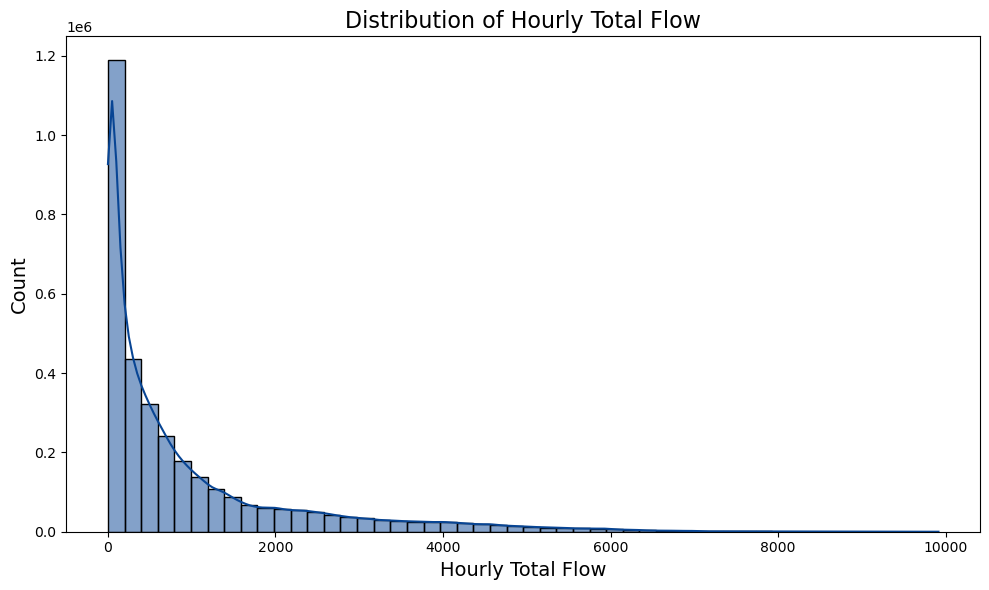

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df['Total Flow'].dropna(), bins=50, kde=True, color="#084594")
plt.title("Distribution of Hourly Total Flow", fontsize=16)
plt.xlabel("Hourly Total Flow", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.tight_layout()
plt.savefig("eda_total_flow_distribution.png", dpi=300)
plt.show()

## Temporal Autocorrelation (Hourly Lag Correlation Plot)

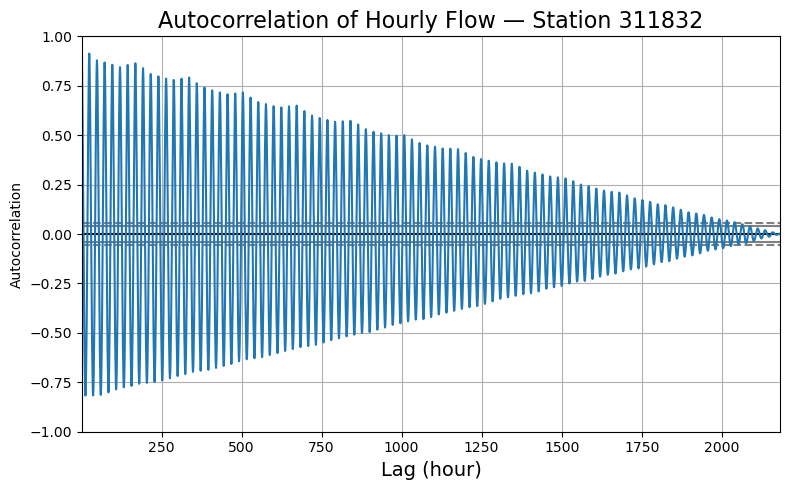

In [101]:
from pandas.plotting import autocorrelation_plot
example_station = df['Station'].value_counts().index[0]
station_ts = df[df['Station']==example_station].sort_values('Timestamp')['Total Flow'].dropna()
plt.figure(figsize=(8,5))
autocorrelation_plot(station_ts)
plt.title(f"Autocorrelation of Hourly Flow — Station {example_station}", fontsize=16)
plt.xlabel("Lag (hour)", fontsize=14)
plt.tight_layout()
plt.savefig("eda_autocorrelation.png", dpi=300)
plt.show()

## Daily Cyclic Pattern (Boxplot by Hour of Day)

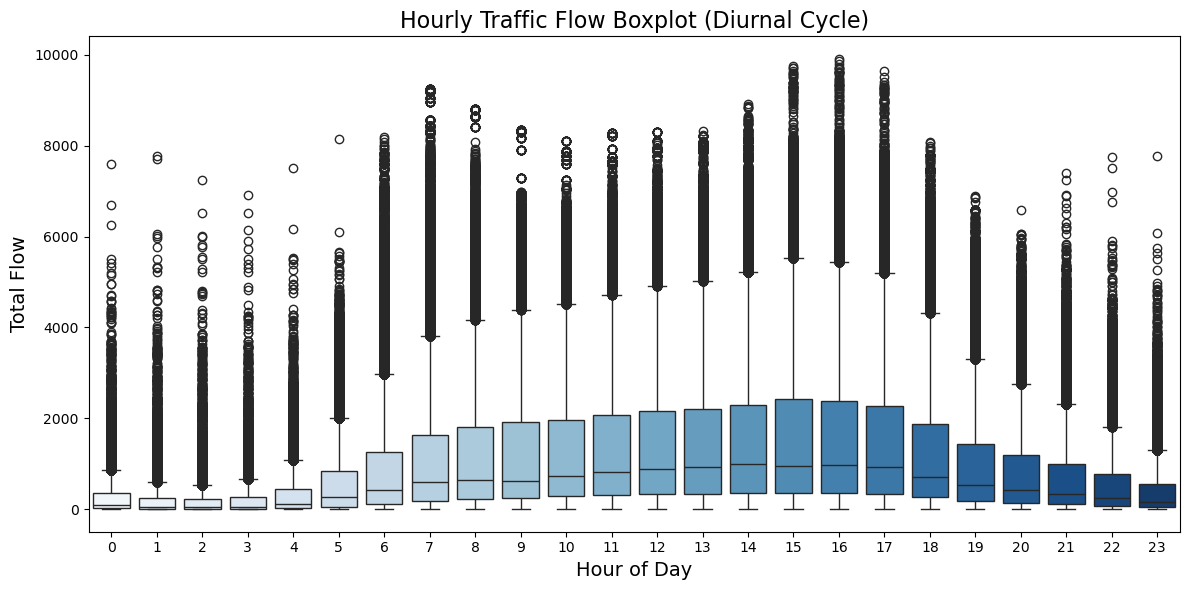

In [102]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,6))
hour = df['Timestamp'].dt.hour
sns.boxplot(x=hour, y=df['Total Flow'], palette="Blues")
plt.title("Hourly Traffic Flow Boxplot (Diurnal Cycle)", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Total Flow", fontsize=14)
plt.tight_layout()
plt.savefig("eda_hourly_boxplot.png", dpi=300)
plt.show()

## Spatial Feature Relationships (Scatter: Upstream vs. Own Flow)

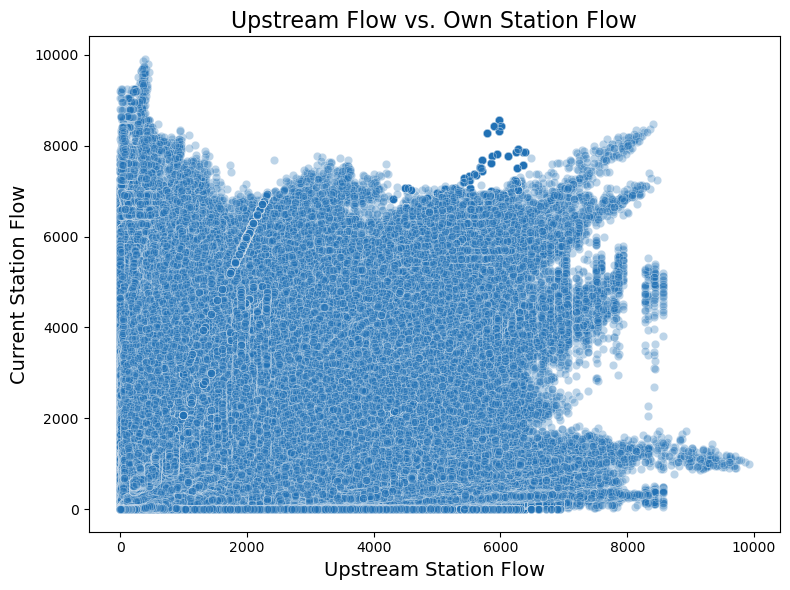

In [103]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['upstream_flow'], y=df['Total Flow'], alpha=0.3, color="#2171b5")
plt.title("Upstream Flow vs. Own Station Flow", fontsize=16)
plt.xlabel("Upstream Station Flow", fontsize=14)
plt.ylabel("Current Station Flow", fontsize=14)
plt.tight_layout()
plt.savefig("eda_spatial_upstream_scatter.png", dpi=300)
plt.show()

## Average Traffic Flow by Hour Plot

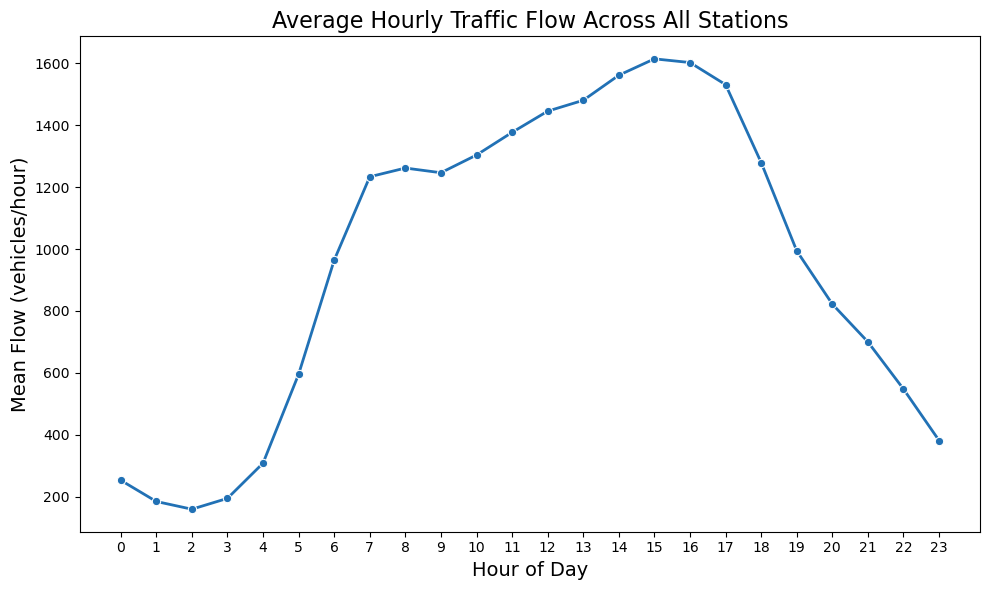

In [104]:
hourly_mean = df.groupby(df['Timestamp'].dt.hour)['Total Flow'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(x='Timestamp', y='Total Flow', data=hourly_mean, marker='o', color="#2171b5", linewidth=2)
plt.title('Average Hourly Traffic Flow Across All Stations', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Mean Flow (vehicles/hour)', fontsize=14)
plt.xticks(range(0,24))
plt.tight_layout()
plt.savefig('eda_average_traffic_flow_by_hour.png', dpi=300)
plt.show()


##  Weekly Cycle (Violin Plot of Flow by Weekday)

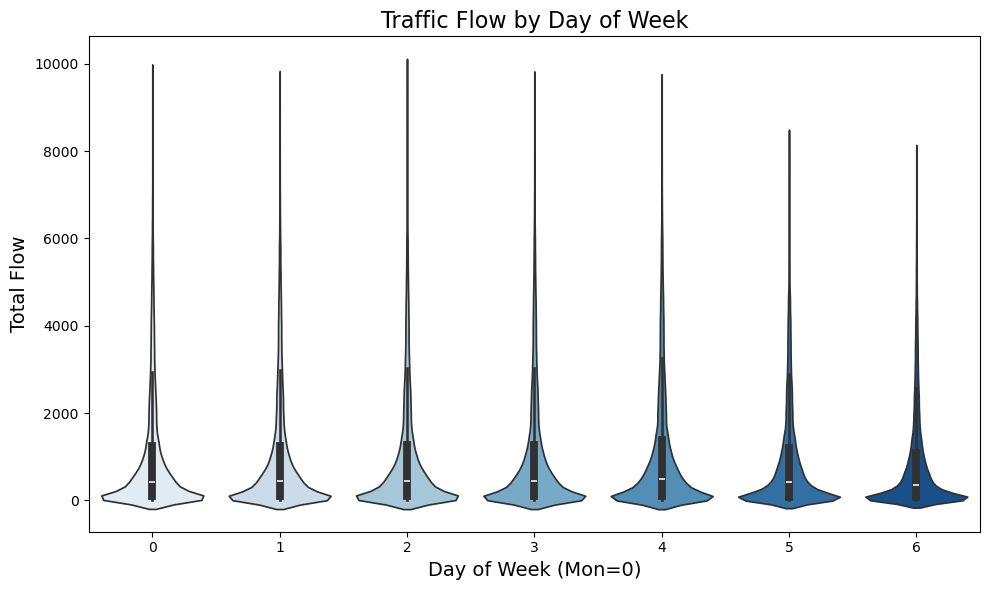

In [105]:
plt.figure(figsize=(10,6))
dow = df['Timestamp'].dt.dayofweek
sns.violinplot(x=dow, y=df['Total Flow'], palette="Blues")
plt.title("Traffic Flow by Day of Week", fontsize=16)
plt.xlabel("Day of Week (Mon=0)", fontsize=14)
plt.ylabel("Total Flow", fontsize=14)
plt.tight_layout()
plt.savefig("eda_weekday_violinplot.png", dpi=300)
plt.show()

## Rolling Mean Trend for a Major Station

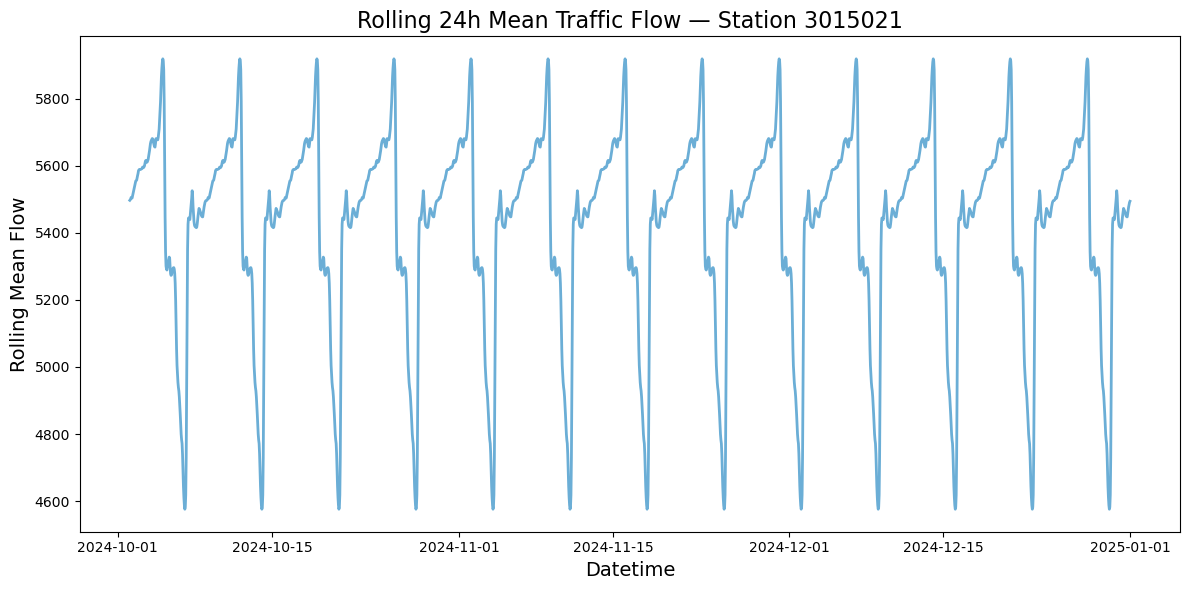

In [106]:
major_station = df['Total Flow'].groupby(df['Station']).mean().idxmax()
station_data = df[df['Station']==major_station].sort_values('Timestamp')
plt.figure(figsize=(12,6))
plt.plot(station_data['Timestamp'], station_data['rolling_mean_24h'], color="#6baed6", linewidth=2)
plt.title(f"Rolling 24h Mean Traffic Flow — Station {major_station}", fontsize=16)
plt.xlabel("Datetime", fontsize=14)
plt.ylabel("Rolling Mean Flow", fontsize=14)
plt.tight_layout()
plt.savefig("eda_rolling_mean_24h.png", dpi=300)
plt.show()

## Median Coefficient of Variation (24h) by Station

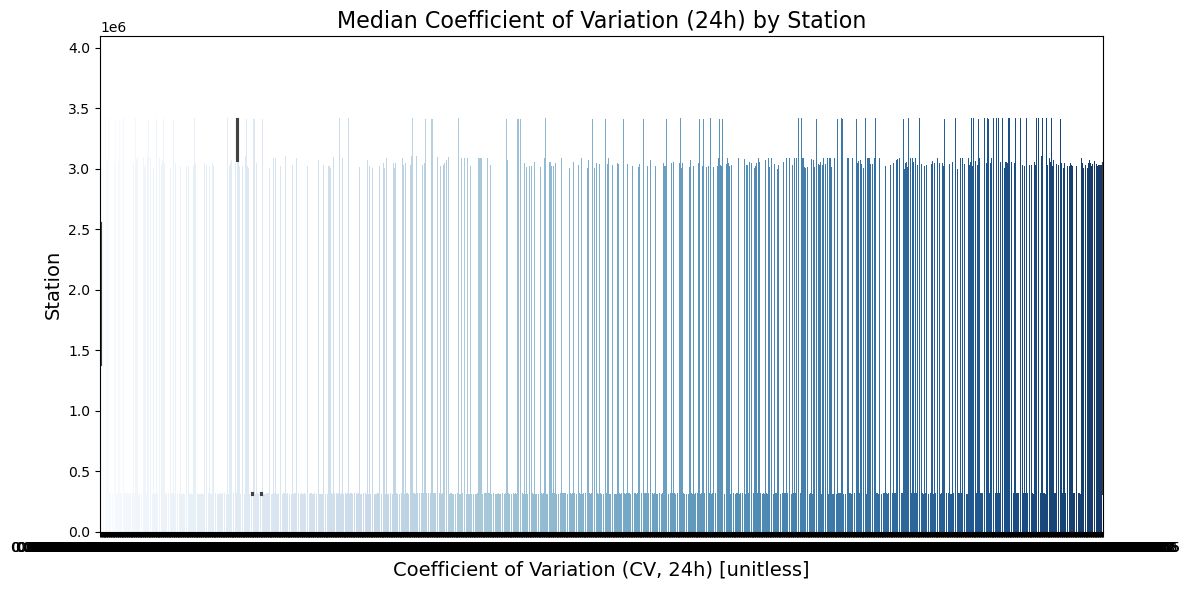

In [107]:
# Aggregate CV per station (median is robust to outliers)
cv_summary = df.groupby('Station')['cv_24h'].median().reset_index()
cv_summary = cv_summary.sort_values('cv_24h', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(y='Station', x='cv_24h', data=cv_summary,
            palette=sns.color_palette('Blues', n_colors=len(cv_summary)))
plt.title('Median Coefficient of Variation (24h) by Station', fontsize=16)
plt.xlabel('Coefficient of Variation (CV, 24h) [unitless]', fontsize=14)
plt.ylabel('Station', fontsize=14)
plt.tight_layout()
plt.savefig('eda_cv24h_station_barplot.png', dpi=300)
plt.show()


## Volatility and Stability (CV_24h Distribution by Station)

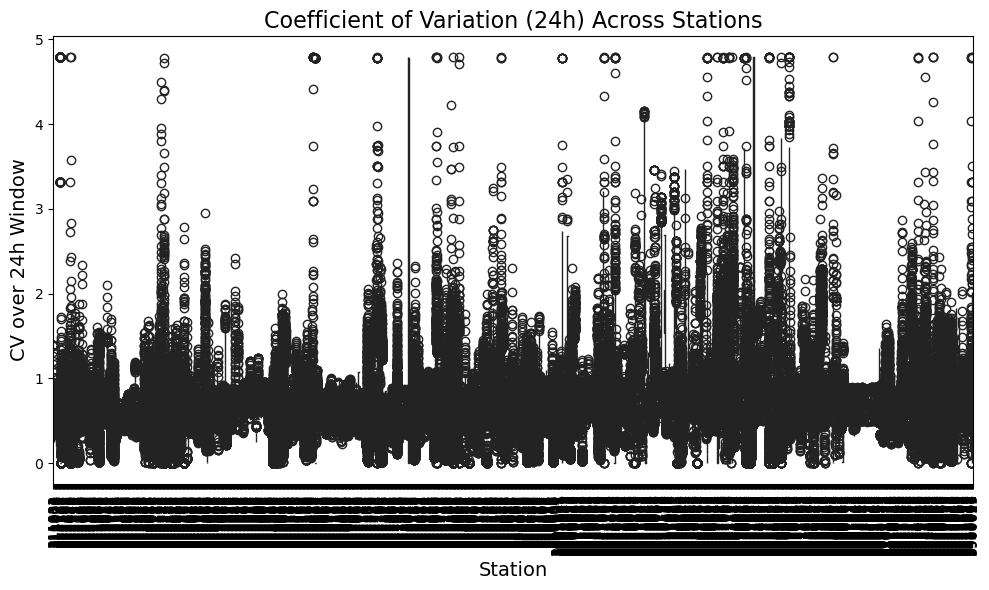

In [108]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['Station'], y=df['cv_24h'], palette="Blues")
plt.title("Coefficient of Variation (24h) Across Stations", fontsize=16)
plt.xlabel("Station", fontsize=14)
plt.ylabel("CV over 24h Window", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("eda_station_cv24h_boxplot.png", dpi=300)
plt.show()

# MODEL BUILDING 


## Linear Regression for Traffic Flow Forecasting

Linear regression is a foundational supervised learning method that models the relationship between a target variable (future traffic flow) and one or more predictor features. It assumes this relationship to be linear, represented mathematically as:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_p x_p + \varepsilon
$$

where (y) is the predicted traffic flow at a given future time, (x_1, \ldots, x_p) are engineered features (spatial, temporal, and raw operational predictors), (\beta_0) is the intercept, (\beta_1, \ldots, \beta_p) are regression coefficients, and (\varepsilon) is the error term.

## Modeling Plan

1. **Feature Set Exploration**
   We will organize features into distinct groups: baseline (raw features), temporal (lags, cycles, rolling statistics), spatial (neighbor flows and lags), and their combinations. This enables rigorous comparison to determine which sets best drive predictive accuracy.

2. **Multi-horizon Prediction**
   The model will be trained to predict (y_{t+72}), the traffic flow 72 hours ahead. Using the same trained model, we will also forecast flow for 12, 24, and 48-hour horizons ((y_{t+12}, y_{t+24}, y_{t+48})) by inputting corresponding lagged and engineered features.

3. **Mathematical Details**
   For each horizon, the regression is formulated as:

   $$
   y_{t+H} = \beta_0 + \sum_{j=1}^{p} \beta_j x_{j,t} + \varepsilon_{t+H}
   $$

   where (H = 12, 24, 48, 72) and (x_{j,t}) are the relevant predictors available at time (t).

4. **Model Evaluation**

   * We evaluate performance using standard metrics: Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Coefficient of Determination ((R^2)) for each prediction horizon.
   * Diagnostic scatter and time-series plots of predicted vs actual flows will visually and quantitatively assess fit.

## Why This Approach?

* **Interpretability:** Linear regression provides direct mappings between feature changes and expected flow responses ((\beta_j)), valuable for understanding traffic drivers.
* **Transparency:** Models with grouped features allow us to report effect sizes and statistical significance for publication.
* **Multi-horizon generalizability:** Training and evaluating at varied forecast lengths tests practical utility and temporal robustness of engineered features.



In [109]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type,station_rank,...,rolling_std_24h,rolling_min_24h,rolling_max_24h,cv_24h,hour_sin,hour_cos,dow_sin,dow_cos,is_peak_hour,is_weekend
6647,2024-10-02 02:00:00,311832,5,S,28.0000,66.6000,92,103,FR,1,...,129.8717,27.0000,415.0000,0.5501,0.5000,0.8660,0.9749,-0.2225,0,0
6648,2024-10-02 03:00:00,311832,5,S,30.0000,66.6000,92,100,FR,1,...,129.6717,28.0000,415.0000,0.5490,0.7071,0.7071,0.9749,-0.2225,0,0
6649,2024-10-02 04:00:00,311832,5,S,41.0000,66.6000,100,114,FR,1,...,129.8582,28.0000,415.0000,0.5501,0.8660,0.5000,0.9749,-0.2225,0,0
6650,2024-10-02 05:00:00,311832,5,S,99.0000,66.6000,100,94,FR,1,...,128.4343,28.0000,415.0000,0.5413,0.9659,0.2588,0.9749,-0.2225,0,0
6651,2024-10-02 06:00:00,311832,5,S,155.0000,66.6000,92,93,FR,1,...,128.6128,28.0000,415.0000,0.5427,1.0000,0.0000,0.9749,-0.2225,0,0



## Preprocessing Summary and Mathematical Rationale

### 1. Chronological Train, Validation, and Test Split

The dataset is partitioned strictly by time to prevent look-ahead bias and preserve temporal causality:

* **Training:** Oct 1 – Nov 16
* **Validation:** Nov 17 – Dec 11
* **Test:** Dec 12 – Dec 31

This ensures that all model learning is based only on information available prior to the future periods being predicted.


## 2. Target Encoding for the Route Feature

To incorporate route-specific behavior while avoiding overfitting on rare categories, a smoothed target encoding is applied.
For each route ( i ), the encoded value is:

$$
\frac{
n_i \cdot \bar{y}*{i,\text{train}}
+
\lambda \cdot \bar{y}*{\text{global,train}}
}{
n_i + \lambda
}
$$


### 3. One-Hot Encoding of Low-Cardinality Features

Categorical features with low cardinality (such as **Lane Type** or **Direction of Travel**) are converted into indicator variables using one-hot encoding with `drop_first=True`. This prevents unnecessary multicollinearity and keeps feature dimensionality minimal.


### **4. Feature Alignment and Cleaning**

After all encoding steps:

* Each split (train, validation, test) contains **identical feature columns**
* Unseen categories in validation or test are assigned zeros
* Non-feature fields such as timestamps, IDs, or text descriptors are removed

This ensures that the model receives a consistent input structure across all periods.


### **5. Standardization of Continuous Variables**

Continuous variables are standardized using statistics from the training set only:

$$
\text{standardized}(x) =
\frac{
x - \mu_{\text{train}}
}{
\sigma_{\text{train}}
}
$$

Applying training-only statistics prevents information leakage from future periods.


### **6. Prevention of Data Leakage**

All preprocessing components including target encoding, one-hot encoding, and scaling—are **fit on the training set exclusively**.
The fitted transformers are then applied to the validation and test sets **without recomputing** statistics.

This approach ensures that no information from future time periods influences the training process.

In [124]:
print("="*80)
print("STEP 1: TEMPORAL SPLIT (70-20-10)")
print("="*80)

# Ensure data is sorted by timestamp
df = df.sort_values('Timestamp').reset_index(drop=True)

total_rows = len(df)
train_size = int(0.70 * total_rows)
val_size = int(0.20 * total_rows)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size+val_size].copy()
test_df = df.iloc[train_size+val_size:].copy()

print(f" Temporal Split Complete:")
print(f"   Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")

print("\n" + "="*80)
print("STEP 2: TARGET ENCODING (Route)")
print("="*80)

# Calculate route means from TRAINING data ONLY
route_means = train_df.groupby('Route')['Total Flow'].agg(['mean', 'count']).reset_index()
route_means.columns = ['Route', 'mean_flow', 'count']

global_mean = train_df['Total Flow'].mean()
lambda_smooth = 1.0

route_means['Route_Encoded'] = (
    route_means['count'] * route_means['mean_flow'] + lambda_smooth * global_mean
) / (route_means['count'] + lambda_smooth)

route_encoding_map = dict(zip(route_means['Route'], route_means['Route_Encoded']))

# Apply to all sets
for df_set_name, df_set in [('train_df', train_df), ('val_df', val_df), ('test_df', test_df)]:
    df_set['Route_Encoded'] = df_set['Route'].map(route_encoding_map)
    df_set['Route_Encoded'].fillna(global_mean, inplace=True)
    df_set.drop('Route', axis=1, inplace=True)
    print(f" Route encoded for {df_set_name}")

print("\n" + "="*80)
print("STEP 3: ONE-HOT ENCODING (Low-Cardinality Categoricals)")
print("="*80)

categorical_cols = ['Lane Type', 'Direction of Travel']

# One-hot encode each set separately
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True, prefix=['Lane', 'Direction'])
val_df = pd.get_dummies(val_df, columns=categorical_cols, drop_first=True, prefix=['Lane', 'Direction'])
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True, prefix=['Lane', 'Direction'])

print(f" One-hot encoding applied to all sets")
print(f"   Train columns after encoding: {train_df.shape[1]}")
print(f"   Val columns after encoding: {val_df.shape[1]}")
print(f"   Test columns after encoding: {test_df.shape[1]}")

# Align columns across all sets
print("\n Aligning columns across train, val, test...")
train_df, val_df = train_df.align(val_df, join='left', axis=1, fill_value=0)
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

print(f"   All sets now have {train_df.shape[1]} columns (aligned)")

print("\n" + "="*80)
print("STEP 4: FEATURE-TARGET SEPARATION")
print("="*80)

# Separate features and target
X_train = train_df.drop(['Total Flow', 'Timestamp'], axis=1, errors='ignore')
y_train = train_df['Total Flow'].copy()

X_val = val_df.drop(['Total Flow', 'Timestamp'], axis=1, errors='ignore')
y_val = val_df['Total Flow'].copy()

X_test = test_df.drop(['Total Flow', 'Timestamp'], axis=1, errors='ignore')
y_test = test_df['Total Flow'].copy()

print(f" Features and targets separated:")
print(f"   X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"   X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"   X_test: {X_test.shape}, y_test: {y_test.shape}")

# Verify column alignment
print(f"\n Column verification:")
print(f"   X_train columns: {X_train.shape[1]}")
print(f"   X_val columns: {X_val.shape[1]}")
print(f"   X_test columns: {X_test.shape[1]}")
print(f"   All aligned: {X_train.shape[1] == X_val.shape[1] == X_test.shape[1]}")

print("\n" + "="*80)
print("STEP 5: CONTINUOUS FEATURE IDENTIFICATION & STANDARDIZATION")
print("="*80)

# Identify continuous features (exclude binary/categorical)
all_numeric = X_train.select_dtypes(include=[np.number]).columns.tolist()
binary_features = [col for col in all_numeric if X_train[col].nunique() <= 2]
continuous_features = [col for col in all_numeric if col not in binary_features]

print(f" Feature types identified:")
print(f"   Total numeric features: {len(all_numeric)}")
print(f"   Binary features (one-hot): {len(binary_features)}")
print(f"   Continuous features (to standardize): {len(continuous_features)}")

# Standardize (fit on train, transform all)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])

X_val_scaled = X_val.copy()
X_val_scaled[continuous_features] = scaler.transform(X_val[continuous_features])

X_test_scaled = X_test.copy()
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])

print(f" Standardization complete:")
print(f"   Scaler fit on training data only")
print(f"   Applied to val and test using training parameters")

print("\n" + "="*80)
print(" PREPROCESSING COMPLETE - READY FOR MODELING")
print("="*80)
print(f"Training: X={X_train_scaled.shape}, y={y_train.shape}")
print(f"Validation: X={X_val_scaled.shape}, y={y_val.shape}")
print(f"Test: X={X_test_scaled.shape}, y={y_test.shape}")
print(f"Continuous features standardized: {len(continuous_features)}")
print(f"\nFirst few feature names: {list(X_train_scaled.columns[:10])}")


STEP 1: TEMPORAL SPLIT (70-20-10)
 Temporal Split Complete:
   Train: 2,362,385 | Val: 674,967 | Test: 337,484

STEP 2: TARGET ENCODING (Route)
 Route encoded for train_df
 Route encoded for val_df
 Route encoded for test_df

STEP 3: ONE-HOT ENCODING (Low-Cardinality Categoricals)
 One-hot encoding applied to all sets
   Train columns after encoding: 40
   Val columns after encoding: 40
   Test columns after encoding: 40

 Aligning columns across train, val, test...
   All sets now have 40 columns (aligned)

STEP 4: FEATURE-TARGET SEPARATION
 Features and targets separated:
   X_train: (2362385, 38), y_train: (2362385,)
   X_val: (674967, 38), y_val: (674967,)
   X_test: (337484, 38), y_test: (337484,)

 Column verification:
   X_train columns: 38
   X_val columns: 38
   X_test columns: 38
   All aligned: True

STEP 5: CONTINUOUS FEATURE IDENTIFICATION & STANDARDIZATION
 Feature types identified:
   Total numeric features: 28
   Binary features (one-hot): 2
   Continuous features (to s

In [132]:
# CORRECTED FEATURE GROUPS (Progressive Addition)
feature_groups_progressive = {
    'Baseline': 
        ['Lane_FR', 'Lane_HV', 'Lane_OR', 'Direction_N', 'Direction_S', 'Direction_W', 'Route_Encoded'],
    
    'Baseline + Temporal': 
        [ 'Direction_N', 'Direction_S', 'Direction_W', 'Route_Encoded',
         'flow_lag_1', 'flow_lag_2', 'flow_lag_3', 'flow_lag_6', 'flow_lag_12', 'flow_lag_24',
         'rolling_mean_24h', 'rolling_std_24h', 'rolling_min_24h', 'rolling_max_24h',
         'cv_24h', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_peak_hour', 'is_weekend'],
    
    'Baseline + Temporal + Spatial':
        ['Direction_N', 'Direction_S', 'Direction_W', 'Route_Encoded',
         'flow_lag_1', 'flow_lag_2', 'flow_lag_3', 'flow_lag_6', 'flow_lag_12', 'flow_lag_24',
         'rolling_mean_24h', 'rolling_std_24h', 'rolling_min_24h', 'rolling_max_24h',
         'cv_24h', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_peak_hour', 'is_weekend',
         'upstream_flow', 'upstream_flow_lag1', 'upstream_flow_lag2', 'downstream_flow',
         'downstream_flow_lag1', 'downstream_flow_lag2','station_rank'],
    
    'All (Baseline + Temporal + Spatial + Exogenous)':
        ['Direction_N', 'Direction_S', 'Direction_W', 'Route_Encoded',
         'flow_lag_1', 'flow_lag_2', 'flow_lag_3', 'flow_lag_6', 'flow_lag_12', 'flow_lag_24',
         'rolling_mean_24h', 'rolling_std_24h', 'rolling_min_24h', 'rolling_max_24h',
         'cv_24h', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_peak_hour', 'is_weekend',
         'upstream_flow', 'upstream_flow_lag1', 'upstream_flow_lag2', 'downstream_flow',
         'downstream_flow_lag1', 'downstream_flow_lag2', 'station_rank',
         'Avg Speed', '% Observed', 'Samples']
}

#  Build and evaluate models
results = {}

for feature_set_name, feature_list in feature_groups_progressive.items():  
    print(f"\nTraining {feature_set_name} ({len(feature_list)} features)...")
    
    # Train single model on y+72 (train data)
    model = LinearRegression()
    model.fit(X_train_scaled[feature_list], y_train)
    
    # Make predictions (same model for all horizons)
    y_pred_val = model.predict(X_val_scaled[feature_list])
    y_pred_test = model.predict(X_test_scaled[feature_list])
    
    # Calculate metrics for test set
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    mae_val = mean_absolute_error(y_val, y_pred_val)
    r2_val = r2_score(y_val, y_pred_val)
    
    # Store results
    results[feature_set_name] = {
        'n_features': len(feature_list),
        'Val_RMSE': rmse_val,
        'Val_MAE': mae_val,
        'Val_R2': r2_val,
        'Test_RMSE': rmse_test,
        'Test_MAE': mae_test,
        'Test_R2': r2_test
    }
    
    print(f"  Val - RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R2: {r2_val:.4f}")
    print(f"  Test - RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R2: {r2_test:.4f}")

# Create comparison table
comparison_df = pd.DataFrame(results).T

print("\n" + "="*100)
print("PROGRESSIVE FEATURE ADDITION: MODEL PERFORMANCE COMPARISON")
print("="*100)
print(comparison_df[['n_features', 'Val_RMSE', 'Val_MAE', 'Val_R2', 'Test_RMSE', 'Test_MAE', 'Test_R2']])

# Display as formatted table
print("\n" + "="*100)
print("FORMATTED RESULTS TABLE:")
print("="*100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(comparison_df.round(4))


Training Baseline (7 features)...
  Val - RMSE: 1073.2953, MAE: 724.3176, R2: 0.3209
  Test - RMSE: 999.4512, MAE: 683.6797, R2: 0.3148

Training Baseline + Temporal (21 features)...
  Val - RMSE: 179.0793, MAE: 102.2769, R2: 0.9811
  Test - RMSE: 165.8417, MAE: 95.3875, R2: 0.9811

Training Baseline + Temporal + Spatial (28 features)...
  Val - RMSE: 171.5299, MAE: 100.1032, R2: 0.9827
  Test - RMSE: 157.5205, MAE: 92.3389, R2: 0.9830

Training All (Baseline + Temporal + Spatial + Exogenous) (31 features)...
  Val - RMSE: 171.5027, MAE: 100.1164, R2: 0.9827
  Test - RMSE: 157.3883, MAE: 92.3163, R2: 0.9830

PROGRESSIVE FEATURE ADDITION: MODEL PERFORMANCE COMPARISON
                                                 n_features  Val_RMSE  \
Baseline                                             7.0000 1073.2953   
Baseline + Temporal                                 21.0000  179.0793   
Baseline + Temporal + Spatial                       28.0000  171.5299   
All (Baseline + Temporal + Spati

## Multi- Horizon Forecast